In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

In [97]:
'''
Purpose: This class represents a single module in the song bird system, aka HVC or RA
'''

class SpikingModule():
    def __init__(self, neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant):
        self.input_matrix = np.random.uniform(-1, 1, (input_count, neuron_count))
        self.internal_connectivity_matrix = np.random.uniform(-1, 1, (neuron_count, neuron_count))
        self.neuron_states = np.random.rand(neuron_count)
        self.output_weights = np.random.rand(neuron_count, output_count)
        self.clock = 0
        self.firing_history = []
        self.input_firing_history = []
        self.output_firing_history = []
        self.decay_rate = decay_rate
        self.learning_rate = learning_rate
        self.time_constant = time_constant
        self.threshold = threshold

        # Initialize freeze masks for input, intra, and output weights
        self.input_freeze_mask = np.zeros_like(self.input_matrix, dtype=bool)
        self.intra_freeze_mask = np.zeros_like(self.internal_connectivity_matrix, dtype=bool)
        self.output_freeze_mask = np.zeros_like(self.output_weights, dtype=bool)

    def stdp(self, learning_rate, time_constant):
        for i in range(len(self.internal_connectivity_matrix)):
            for j in range(len(self.internal_connectivity_matrix[i])):
                if i == j or self.intra_freeze_mask[i, j]:
                    continue

                last_spike_i = self._find_last_spike(i)
                last_spike_j = self._find_last_spike(j)

                if last_spike_i is not None and last_spike_j is not None:
                    delta_t = self.clock - last_spike_i - last_spike_j
                    if delta_t > 0:
                        self.internal_connectivity_matrix[i][j] += learning_rate * np.exp(-delta_t / time_constant)
                    elif delta_t < 0:
                        self.internal_connectivity_matrix[i][j] -= learning_rate * np.exp(delta_t / time_constant)

        self.internal_connectivity_matrix = np.clip(self.internal_connectivity_matrix, -1, 1)

    def _find_last_spike(self, neuron_index):
        last_spike = None
        for time_step, fired_neurons in enumerate(reversed(self.firing_history)):
            if np.isin(neuron_index, fired_neurons):
                last_spike = self.clock - time_step - 1
                break
        return last_spike

    def step(self, input):
        self.neuron_states = self.neuron_states + self.internal_connectivity_matrix.dot(self.neuron_states) + self.input_matrix.T.dot(input)
        self.neuron_states = self.neuron_states * self.decay_rate
        self.neuron_states[np.where(self.neuron_states < 0)] = 0
        fired_neurons = np.where(self.neuron_states > self.threshold)
        self.firing_history.append(fired_neurons)
        self.neuron_states[fired_neurons] = 0
        self.clock += 1

        learning_rate = 0.01
        time_constant = 20
        self.stdp(learning_rate, time_constant)

    def set_input_weights(self, input_weights):
        self.input_matrix = np.array(input_weights)

    def set_internal_weights(self, internal_weights):
        self.internal_connectivity_matrix = np.array(internal_weights)

    def get_output(self):
        output = self.output_weights.T.dot(self.neuron_states)
        return output

    def set_input_weights(self, input_weights):
        self.input_matrix = input_weights

    def set_internal_weights(self, internal_weights):
        self.internal_connectivity_matrix = internal_weights

    def set_output_weights(self, output_weights):
        self.output_weights = output_weights

    def visualize_firing_history(self):
        # Plot the firing history
        plt.figure()
        for i in range(len(self.input_firing_history)):
            fired_neurons = self.input_firing_history[i]
            for neuron in np.where(fired_neurons == 1)[0]:
                plt.plot(i, neuron, marker='o', markersize=5, linestyle='None', color='gold')
        for i in range(len(self.firing_history)):
            fired_neurons = self.firing_history[i]
            for neuron in np.where(fired_neurons == 1)[0]:
                plt.plot(i, neuron + self.input_matrix.shape[0], marker='o', markersize=5, linestyle='None', color='skyblue')
        for i in range(len(self.output_firing_history)):
            fired_neurons = self.output_firing_history[i]
            for neuron in np.where(fired_neurons == 1)[0]:
                plt.plot(i, neuron + self.input_matrix.shape[0] + self.internal_connectivity_matrix.shape[0], marker='o', markersize=5, linestyle='None', color='limegreen')
        plt.xlabel('Time Step')
        plt.ylabel('Neuron Index')
        plt.title('Firing History')
        plt.show()

    def visualize_directed_graph(self):
        # Create a directed graph
        G = nx.DiGraph()

        # Add input, neuron, and output nodes
        input_nodes = range(self.input_matrix.shape[0])
        neuron_nodes = range(len(input_nodes), len(input_nodes) + len(self.neuron_states))
        output_nodes = range(len(neuron_nodes), len(neuron_nodes) + self.output_weights.shape[1])

        for node in input_nodes:
            G.add_node(node, node_type='input')
        for node in neuron_nodes:
            G.add_node(node, node_type='neuron')
        for node in output_nodes:
            G.add_node(node, node_type='output')

        # Add edges based on input, internal, and output connectivity matrices
        for i in range(len(self.input_matrix)):
            for j in range(len(self.input_matrix[i])):
                weight = self.input_matrix[i][j]
                G.add_edge(i, j + len(input_nodes), weight=weight)
        for i in range(len(self.internal_connectivity_matrix)):
            for j in range(len(self.internal_connectivity_matrix[i])):
                if i == j:
                    continue
                weight = self.internal_connectivity_matrix[i][j]
                G.add_edge(i + len(input_nodes), j + len(input_nodes), weight=weight)
        for i in range(len(self.output_weights)):
            for j in range(len(self.output_weights[i])):
                weight = self.output_weights[i][j]
                G.add_edge(i + len(input_nodes), j + len(neuron_nodes), weight=weight)

        # Position input nodes on the left, output nodes on the right, and neuron nodes in between
        pos = {}
        for node in input_nodes:
            pos[node] = (0, (node / len(input_nodes)) * 2 - 1)
        for node in neuron_nodes:
            pos[node] = (0.5, (node - len(input_nodes)) / len(neuron_nodes) * 2 - 1)
        for node in output_nodes:
            pos[node] = (1, (node - len(neuron_nodes)) / len(output_nodes) * 2 - 1)

        # Plot the network
        fig, ax = plt.subplots()

        # Draw input, neuron, and output nodes with different colors
        input_colors = ['gold'] * len(input_nodes)
        neuron_colors = ['skyblue'] * len(neuron_nodes)
        output_colors = ['limegreen'] * len(output_nodes)
        nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_size=1000, node_color=input_colors, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=neuron_nodes, node_size=1000, node_color=neuron_colors, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=output_nodes, node_size=1000, node_color=output_colors, ax=ax)

        # Draw edges with varying thickness based on weights and different colors for inhibitory and excitatory connections
        for (u, v, d) in G.edges(data=True):
            weight = d['weight']
            edge_color = "red" if weight < 0 else "black"
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=abs(weight) * 5, edge_color=edge_color, ax=ax)

        # Draw node labels
        nx.draw_networkx_labels(G, pos, font_size=10,font_weight='bold', ax=ax)

    def freeze_weights(self, selected_neurons, percent_to_freeze, neurons=None):
        """
        Purpose:
        - Freeze the specified percentage of weights for the selected neurons or specific neurons.
        Args:
        - selected_neurons (str): 'input', 'intra', or 'output' to choose which weights to freeze.
        - percent_to_freeze (float): The percentage of weights to freeze (between 0 and 1).
        - neurons (list of int, optional): The indices of specific neurons to freeze. If not provided, weights are frozen randomly.
        """

        if selected_neurons not in ('input', 'intra', 'output'):
            raise ValueError("selected_neurons must be one of 'input', 'intra', or 'output'.")

        if not 0 <= percent_to_freeze <= 1:
            raise ValueError("percent_to_freeze must be between 0 and 1.")

        # Choose the weight matrix based on selected_neurons
        if selected_neurons == 'input':
            weight_matrix = self.input_matrix
        elif selected_neurons == 'intra':
            weight_matrix = self.internal_connectivity_matrix
        else:
            weight_matrix = self.output_weights

        # Create a mask to indicate frozen weights
        freeze_mask = np.zeros_like(weight_matrix, dtype=bool)

        if neurons is not None:
            if not all(isinstance(n, int) for n in neurons):
                raise ValueError("neurons must be a list of integers.")

            # Freeze all weights for the specified neurons
            for neuron_index in neurons:
                if selected_neurons == 'input':
                    freeze_mask[:, neuron_index] = True
                elif selected_neurons == 'intra':
                    freeze_mask[neuron_index, :] = True
                    freeze_mask[:, neuron_index] = True
                else:
                    freeze_mask[neuron_index, :] = True
        else:
            # Calculate the number of weights to freeze
            num_weights_to_freeze = int(np.prod(weight_matrix.shape) * percent_to_freeze)

            # Choose the indices of the weights to freeze
            freeze_indices = np.random.choice(np.arange(weight_matrix.size), num_weights_to_freeze, replace=False)
            freeze_mask.ravel()[freeze_indices] = True

        # Assign the freeze_mask to the corresponding attribute
        if selected_neurons == 'input':
            self.input_freeze_mask = freeze_mask
        elif selected_neurons == 'intra':
            self.intra_freeze_mask = freeze_mask
        else:
            self.output_freeze_mask = freeze_mask


    def remove_connection(self, selected_neurons, neuron_indices):
        """
        Purpose:
        - Set a certain weight to zero and freeze it permanently (remove the connection).
        Args:
        - selected_neurons (str): 'input', 'intra', or 'output' to choose which weights to remove.
        - neuron_indices (tuple): A tuple containing two indices (i, j) representing the weight to remove.
        """

        if selected_neurons not in ('input', 'intra', 'output'):
            raise ValueError("selected_neurons must be one of 'input', 'intra', or 'output'.")

        if not isinstance(neuron_indices, tuple) or len(neuron_indices) != 2 or not all(isinstance(n, int) for n in neuron_indices):
            raise ValueError("neuron_indices must be a tuple of two integers.")

        i, j = neuron_indices

        # Remove the connection and freeze the weight
        if selected_neurons == 'input':
            self.input_matrix[i, j] = 0
            self.input_freeze_mask[i, j] = True
        elif selected_neurons == 'intra':
            self.internal_connectivity_matrix[i, j] = 0
            self.intra_freeze_mask[i, j] = True
        else:
            self.output_weights[i, j] = 0
            self.output_freeze_mask[i, j] = True

    def no_input_step(self):
        """
        Purpose:
        - Perform a single time step of the network without any input.
        """

        self.step(np.zeros(self.input_matrix.shape[0]))

### Testing the SpikingModule Class

AttributeError: 'SpikingModule' object has no attribute 'neuron_firing_history'

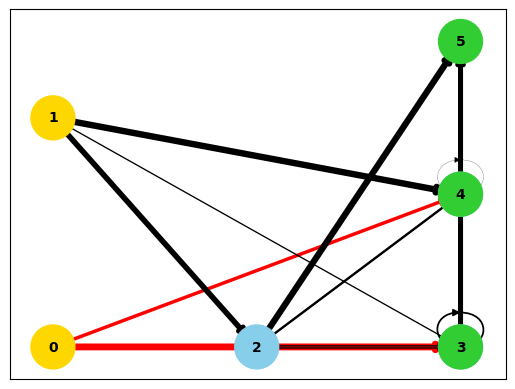

<Figure size 640x480 with 0 Axes>

In [99]:
neuron_count = 3
input_count = 2
output_count = 3
decay_rate = 0.99
threshold = 1
learning_rate = 0.01
time_constant = 20

module = SpikingModule(neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant)
# module.freeze_weights('input', 0.5)

for _ in range(100):
    input = [1,1]
    module.step(input)

module.visualize_directed_graph()
module.visualize_firing_history()

### Testing the HVC Ability to Learn a Song Sequence

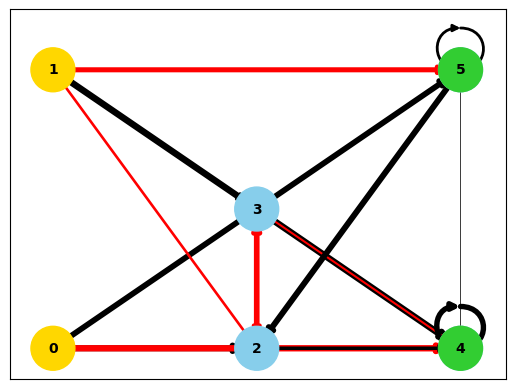

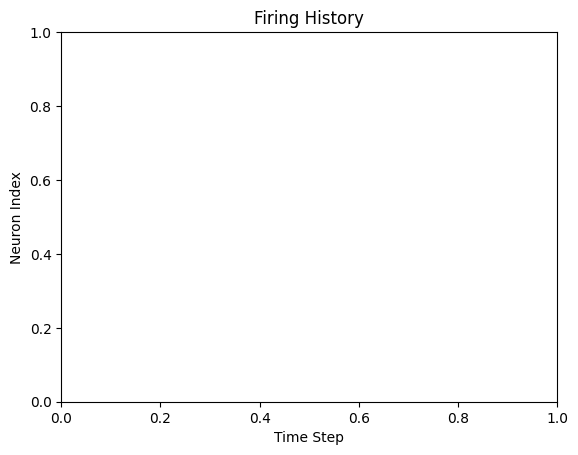

ValueError: shapes (4,2) and (5,) not aligned: 2 (dim 1) != 5 (dim 0)

In [85]:
HVC = SpikingModule(neuron_count=4, input_count=2, output_count=2, decay_rate=0.5, threshold=2, learning_rate=0.01, time_constant=38)

cycle_count = 100
cycle = 0

# create a one to one mapping of the first 5 inputs to the first 5 neurons
# Get the number of neurons and inputs
num_neurons = module.internal_connectivity_matrix.shape[0]
num_inputs = module.input_matrix.shape[0]

# Loop through all the connections
for input_idx in range(num_inputs):
    for neuron_idx in range(num_neurons):
        # Skip the one-to-one mappings for the first 5 neurons and inputs
        if input_idx == neuron_idx and input_idx < 5:
            continue
        module.remove_connection('input', (input_idx, neuron_idx))

HVC.visualize_network()

# while cycle < cycle_count:
#     input = [2,0,0,0,0]
#     HVC.step(input)
#     for i in range(10):
#         HVC.no_input_step()
#     cycle+=10
#     input = [0,2,0,0,0]
#     HVC.step(input)
#     for i in range(10):
#         HVC.no_input_step()
#     cycle+=10
#     input = [0,0,2,0,0]
#     HVC.step(input)
#     for i in range(10):
#         HVC.no_input_step()
#     cycle+=10
#     input = [0,0,0,2,0]
#     HVC.step(input)
#     for i in range(10):
#         HVC.no_input_step()
#     cycle+=10
#     input = [0,0,0,0,2]
#     HVC.step(input)
#     for i in range(10):
#         HVC.no_input_step()
#     cycle += 10

#     for i in range(100):
#         HVC.no_input_step()
#     cycle += 100
    
# HVC.visualize_network()